In [1]:
import pandas as pd

df = pd.read_csv("covtype.data.gz", header=None)

print(df.shape)  
print(df.head()) 


(581012, 55)
     0    1   2    3    4     5    6    7    8     9   ...  45  46  47  48  \
0  2596   51   3  258    0   510  221  232  148  6279  ...   0   0   0   0   
1  2590   56   2  212   -6   390  220  235  151  6225  ...   0   0   0   0   
2  2804  139   9  268   65  3180  234  238  135  6121  ...   0   0   0   0   
3  2785  155  18  242  118  3090  238  238  122  6211  ...   0   0   0   0   
4  2595   45   2  153   -1   391  220  234  150  6172  ...   0   0   0   0   

   49  50  51  52  53  54  
0   0   0   0   0   0   5  
1   0   0   0   0   0   5  
2   0   0   0   0   0   2  
3   0   0   0   0   0   2  
4   0   0   0   0   0   5  

[5 rows x 55 columns]


In [2]:
from pathlib import Path

path = Path("covtype.info")
text = path.read_text(encoding="utf-8", errors="ignore")
for i, line in enumerate(text.splitlines(), start=1):
    print(f"{i:03d}: {line}")


001: The Forest CoverType dataset
002: 
003: 
004: 1.	Title of Database:
005: 
006: 	Forest Covertype data
007: 
008: 
009: 2.	Sources:
010: 
011: 	(a) Original owners of database:
012: 		Remote Sensing and GIS Program
013: 		Department of Forest Sciences
014: 		College of Natural Resources
015: 		Colorado State University
016: 		Fort Collins, CO  80523
017: 		(contact Jock A. Blackard, jblackard 'at' fs.fed.us
018: 		      or Dr. Denis J. Dean, denis.dean 'at' utdallas.edu)
019: 
020: 	NOTE:	Reuse of this database is unlimited with retention of 
021: 		copyright notice for Jock A. Blackard and Colorado 
022: 		State University.
023: 
024: 	(b) Donors of database:
025: 		Jock A. Blackard (jblackard 'at' fs.fed.us)
026: 		GIS Coordinator
027: 		USFS - Forest Inventory & Analysis
028: 		Rocky Mountain Research Station
029: 		507 25th Street
030: 		Ogden, UT 84401
031: 
032: 		Dr. Denis J. Dean (denis.dean 'at' utdallas.edu)
033: 		Professor
034: 		Program in Geography and Geospatial Scie

In [3]:
from pathlib import Path

path = Path("old_covtype.info")
text = path.read_text(encoding="utf-8", errors="ignore")
for i, line in enumerate(text.splitlines(), start=1):
    print(f"{i:03d}: {line}")


001: The Forest CoverType dataset
002: 
003: 
004: 1.	Title of Database:
005: 
006: 	Forest Covertype data
007: 
008: 
009: 2.	Sources:
010: 
011: 	(a) Original owners of database:
012: 		Remote Sensing and GIS Program
013: 		Department of Forest Sciences
014: 		College of Natural Resources
015: 		Colorado State University
016: 		Fort Collins, CO  80523
017: 		(contact Jock A. Blackard, jblackard/wo_ftcol@fs.fed.us
018: 		      or Dr. Denis J. Dean, denis@cnr.colostate.edu)
019: 
020: 	NOTE:	Reuse of this database is unlimited with retention of 
021: 		copyright notice for Jock A. Blackard and Colorado State University.
022: 
023: 	(b) Donors of database:
024: 		Jock A. Blackard (jblackard/wo_ftcol@fs.fed.us)
025: 		USDA Forest Service
026: 		3825 E. Mulberry
027: 		Fort Collins, CO  80524  USA
028: 
029: 		Dr. Denis J. Dean (denis@cnr.colostate.edu)
030: 		Associate Professor
031: 		Department of Forest Sciences
032: 		Colorado State University
033: 		Fort Collins, CO  80523  USA
034:

In [4]:
import re
from pathlib import Path
import pandas as pd

INFO_FILE = "covtype.info"
DATA_FILE = "covtype.data.gz"

def parse_covtype_schema_from_table(info_path=INFO_FILE):
    text = Path(info_path).read_text(encoding="utf-8", errors="ignore")
    lines = text.splitlines()

    # 1) Locate the schema table header line
    header_idx = None
    for i, ln in enumerate(lines):
        if re.search(r"^\s*Name\b", ln) and re.search(r"\bData\s*Type\b", ln, re.IGNORECASE):
            header_idx = i
            break
    if header_idx is None:
        raise RuntimeError("Could not find the 'Name  Data Type ...' header in covtype.info")

    # 2) Collect table rows:
    #    - Skip any blank lines immediately after the header
    #    - Then accumulate until we hit a terminating line (blank AFTER we started, or next section)
    rows = []
    started = False
    for ln in lines[header_idx + 1:]:
        # Stop on next section markers
        if re.search(r"^\s*(Code\s+Designations|Forest\s+Cover\s+Type\s+Classes|8\.)\b", ln, re.IGNORECASE):
            break

        if not ln.strip():
            # If we haven't started rows yet, keep skipping
            if not started:
                continue
            # If we've started and hit a blank, table is done
            break

        started = True
        rows.append(ln)

    if not rows:
        raise RuntimeError("Found header but no rows. Check file formatting around the schema table.")

    # 3) Extract the left-most 'Name' from each row.
    #    The table is aligned with multiple spaces or tabs separating columns.
    entries = []
    for ln in rows:
        # Try: split by >=2 spaces OR tabs; first field is the Name (may include "(...)" group info)
        parts = re.split(r"\s{2,}|\t+", ln.strip())
        if not parts:
            continue
        name = parts[0]  # e.g., "Elevation" or "Wilderness_Area (4 binary columns)"
        entries.append((name, ln))

    # 4) Build ordered column list
    cols = []
    wild_n = None
    soil_n = None

    for name, full_line in entries:
        # Strip any trailing "(...)" group info to get base name
        base = re.sub(r"\s*\(.*?\)\s*$", "", name).strip()

        # Expand groups or add single names
        if base.lower().startswith("wilderness_area"):
            mnum = re.search(r"\((\d+)\s+binary", full_line, flags=re.IGNORECASE)
            wild_n = int(mnum.group(1)) if mnum else 4
            cols.extend([f"Wilderness_Area{i}" for i in range(1, wild_n + 1)])
        elif base.lower().startswith("soil_type"):
            mnum = re.search(r"\((\d+)\s+binary", full_line, flags=re.IGNORECASE)
            soil_n = int(mnum.group(1)) if mnum else 40
            cols.extend([f"Soil_Type{i}" for i in range(1, soil_n + 1)])
        elif base.lower().startswith("cover_type"):
            cols.append("Cover_Type")
        else:
            # One of the 10 continuous variables (keep exact spelling from file)
            cols.append(base)

    # Defaults (shouldn’t be needed for your file)
    if wild_n is None:
        wild_n = 4
    if soil_n is None:
        soil_n = 40

    if len(cols) != 10 + wild_n + soil_n + 1:
        raise RuntimeError(f"Parsed {len(cols)} columns (expected 55). Parsed names:\n{cols}")

    return cols

# --- Use it ---
cols = parse_covtype_schema_from_table(INFO_FILE)

print("Index -> Column name mapping:")
for i, c in enumerate(cols):
    print(f"{i:02d} -> {c}")

# Load and verify
df = pd.read_csv(DATA_FILE, header=None, names=cols)
print("\nData shape:", df.shape)
print(df.head())

# Optional: quick checks on one-hot columns
w_cols = [c for c in cols if c.startswith("Wilderness_Area")]
s_cols = [c for c in cols if c.startswith("Soil_Type")]
print("\nRow-wise one-hot sums (should be 1):")
print("Wilderness:", df[w_cols].sum(axis=1).value_counts().head().to_dict())
print("Soil:", df[s_cols].sum(axis=1).value_counts().head().to_dict())


Index -> Column name mapping:
00 -> Elevation
01 -> Aspect
02 -> Slope
03 -> Horizontal_Distance_To_Hydrology
04 -> Vertical_Distance_To_Hydrology
05 -> Horizontal_Distance_To_Roadways
06 -> Hillshade_9am
07 -> Hillshade_Noon
08 -> Hillshade_3pm
09 -> Horizontal_Distance_To_Fire_Points
10 -> Wilderness_Area1
11 -> Wilderness_Area2
12 -> Wilderness_Area3
13 -> Wilderness_Area4
14 -> Soil_Type1
15 -> Soil_Type2
16 -> Soil_Type3
17 -> Soil_Type4
18 -> Soil_Type5
19 -> Soil_Type6
20 -> Soil_Type7
21 -> Soil_Type8
22 -> Soil_Type9
23 -> Soil_Type10
24 -> Soil_Type11
25 -> Soil_Type12
26 -> Soil_Type13
27 -> Soil_Type14
28 -> Soil_Type15
29 -> Soil_Type16
30 -> Soil_Type17
31 -> Soil_Type18
32 -> Soil_Type19
33 -> Soil_Type20
34 -> Soil_Type21
35 -> Soil_Type22
36 -> Soil_Type23
37 -> Soil_Type24
38 -> Soil_Type25
39 -> Soil_Type26
40 -> Soil_Type27
41 -> Soil_Type28
42 -> Soil_Type29
43 -> Soil_Type30
44 -> Soil_Type31
45 -> Soil_Type32
46 -> Soil_Type33
47 -> Soil_Type34
48 -> Soil_Type35


In [5]:
import pandas as pd

DATA_PATH = "covtype.data.gz"

# 1) Read: 55 columns total (54 features + 1 target), no header in the file
df = pd.read_csv(DATA_PATH, header=None)

print("Shape:", df.shape)       
print(df.head(3))               

Shape: (581012, 55)
     0    1   2    3   4     5    6    7    8     9   ...  45  46  47  48  49  \
0  2596   51   3  258   0   510  221  232  148  6279  ...   0   0   0   0   0   
1  2590   56   2  212  -6   390  220  235  151  6225  ...   0   0   0   0   0   
2  2804  139   9  268  65  3180  234  238  135  6121  ...   0   0   0   0   0   

   50  51  52  53  54  
0   0   0   0   0   5  
1   0   0   0   0   5  
2   0   0   0   0   2  

[3 rows x 55 columns]


In [7]:
# Cover_Type is the last column (index 54)
target_col = 54  

# Select rows where Cover_Type ∈ {3,6,7}
keep_classes = [3, 6, 7]
df_sub = df[df[target_col].isin(keep_classes)].copy()

print("Subset shape:", df_sub.shape)
print("Class counts:\n", df_sub[target_col].value_counts().sort_index())

# Save to CSV (compressed for convenience)
df_sub.to_csv("covtype_subset_3classes.csv", index=False)

# Or gzipped version
df_sub.to_csv("covtype_subset_3classes.csv.gz", index=False, compression="gzip")


Subset shape: (73631, 55)
Class counts:
 54
3    35754
6    17367
7    20510
Name: count, dtype: int64


In [8]:
import pandas as pd

# Load the subset (CSV version)
df_check = pd.read_csv("covtype_subset_3classes.csv")

print("Shape:", df_check.shape)            # should be (73631, 55)
print("First 3 rows:\n", df_check.head(3))
print("\nClass counts:\n", df_check.iloc[:, -1].value_counts().sort_index())


Shape: (73631, 55)
First 3 rows:
       0    1   2    3   4     5    6    7    8     9  ...  45  46  47  48  49  \
0  3273  159  12  300  55  2863  233  242  138  2439  ...   0   0   0   0   0   
1  3264  137  10  283  45  2773  236  236  131  2529  ...   0   0   0   0   0   
2  3256  143   7  234  37  2713  231  239  140  2589  ...   0   0   0   0   0   

   50  51  52  53  54  
0   0   0   0   0   7  
1   0   0   0   0   7  
2   0   0   0   0   7  

[3 rows x 55 columns]

Class counts:
 54
3    35754
6    17367
7    20510
Name: count, dtype: int64


In [9]:
# df currently has columns 0..54
df.columns = cols   # use the 'cols' you parsed
print(df.head(2))
print(df.columns.tolist()[-5:])  # sanity check last few columns -> ..., 'Soil_Type40','Cover_Type'
import pandas as pd

df_sub = pd.read_csv("covtype_subset_3classes.csv", header=None)  # no header in file you saved
df_sub.columns = cols
print(df_sub.shape, df_sub.columns[-1])  # should show Cover_Type as last col
print(df_sub["Cover_Type"].value_counts().sort_index())


   Elevation  Aspect  Slope  Horizontal_Distance_To_Hydrology  \
0       2596      51      3                               258   
1       2590      56      2                               212   

   Vertical_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
0                               0                              510   
1                              -6                              390   

   Hillshade_9am  Hillshade_Noon  Hillshade_3pm  \
0            221             232            148   
1            220             235            151   

   Horizontal_Distance_To_Fire_Points  ...  Soil_Type32  Soil_Type33  \
0                                6279  ...            0            0   
1                                6225  ...            0            0   

   Soil_Type34  Soil_Type35  Soil_Type36  Soil_Type37  Soil_Type38  \
0            0            0            0            0            0   
1            0            0            0            0            0   

   Soil_Typ

In [10]:
df_sub.to_csv("covtype_subset_3classes_named.csv", index=False)


In [11]:
import pandas as pd

# Load the new file
df_check = pd.read_csv("covtype_subset_3classes_named.csv")

print("Shape:", df_check.shape)           # should be (73631, 55)
print("Columns:", df_check.columns[:12]) # first few column names
print("Last columns:", df_check.columns[-5:])  # last few, should end with Soil_Type40, Cover_Type

# Peek at the first 3 rows
print("\nFirst 3 rows:\n", df_check.head(3))

# Confirm class distribution
print("\nClass counts:\n", df_check["Cover_Type"].value_counts().sort_index())


Shape: (73632, 55)
Columns: Index(['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
       'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
       'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area1',
       'Wilderness_Area2'],
      dtype='object')
Last columns: Index(['Soil_Type37', 'Soil_Type38', 'Soil_Type39', 'Soil_Type40',
       'Cover_Type'],
      dtype='object')

First 3 rows:
    Elevation  Aspect  Slope  Horizontal_Distance_To_Hydrology  \
0          0       1      2                                 3   
1       3273     159     12                               300   
2       3264     137     10                               283   

   Vertical_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
0                               4                                5   
1                              55                             2863   
2                              45  

In [12]:
df_check = pd.read_csv("covtype_subset_3classes_named.csv", header=0)
print(df_check.shape)   # should be (73631, 55)
print(df_check.head(3))
print(df_check["Cover_Type"].value_counts().sort_index())


(73632, 55)
   Elevation  Aspect  Slope  Horizontal_Distance_To_Hydrology  \
0          0       1      2                                 3   
1       3273     159     12                               300   
2       3264     137     10                               283   

   Vertical_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
0                               4                                5   
1                              55                             2863   
2                              45                             2773   

   Hillshade_9am  Hillshade_Noon  Hillshade_3pm  \
0              6               7              8   
1            233             242            138   
2            236             236            131   

   Horizontal_Distance_To_Fire_Points  ...  Soil_Type32  Soil_Type33  \
0                                   9  ...           45           46   
1                                2439  ...            0            0   
2                        

In [13]:
# Drop row where Cover_Type == 54
df_check = df_check[df_check["Cover_Type"].isin([3,6,7])]

# Reset index
df_check = df_check.reset_index(drop=True)

# Save clean version
df_check.to_csv("covtype_subset_3classes_named_clean.csv", index=False)

print(df_check.shape)   # should be (73631, 55)
print(df_check["Cover_Type"].value_counts().sort_index())


(73631, 55)
Cover_Type
3    35754
6    17367
7    20510
Name: count, dtype: int64


In [15]:
# Put all importances into a DataFrame
all_importances = pd.DataFrame({
    "feature": feature_cols,
    "importance": rf.feature_importances_
}).sort_values("importance", ascending=False)

# Show top rows
print(all_importances.head(20))

# Save all feature importance values to CSV (optional)
all_importances.to_csv("feature_importances_all.csv", index=False)


                               feature  importance
0                            Elevation    0.271836
5      Horizontal_Distance_To_Roadways    0.128711
9   Horizontal_Distance_To_Fire_Points    0.092706
3     Horizontal_Distance_To_Hydrology    0.048518
4       Vertical_Distance_To_Hydrology    0.039450
1                               Aspect    0.037929
6                        Hillshade_9am    0.034999
13                    Wilderness_Area4    0.033265
52                         Soil_Type39    0.032939
7                       Hillshade_Noon    0.032688
51                         Soil_Type38    0.031617
17                          Soil_Type4    0.028225
8                        Hillshade_3pm    0.027815
2                                Slope    0.025428
23                         Soil_Type10    0.023276
10                    Wilderness_Area1    0.018095
15                          Soil_Type2    0.012803
53                         Soil_Type40    0.012783
12                    Wildernes

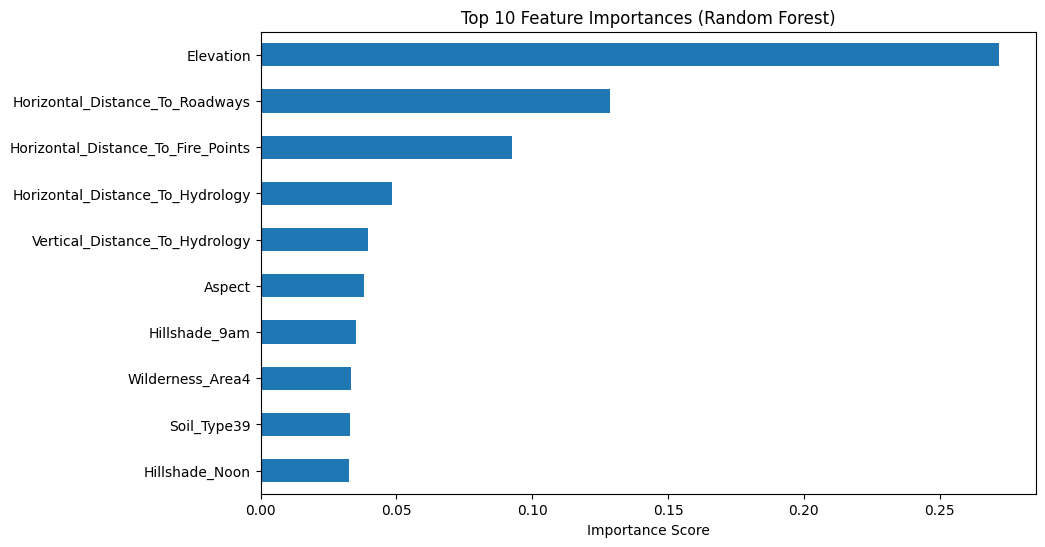

In [14]:
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

# Features and target
feature_cols = [c for c in df_check.columns if c != "Cover_Type"]
X = df_check[feature_cols]
y = df_check["Cover_Type"]

# Train Random Forest
rf = RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1)
rf.fit(X, y)

# Get importance values
importances = pd.Series(rf.feature_importances_, index=feature_cols)

# Select top 10
top_features = importances.sort_values(ascending=False).head(10)

# Plot
plt.figure(figsize=(10,6))
top_features.plot(kind="barh")
plt.gca().invert_yaxis()  # largest on top
plt.title("Top 10 Feature Importances (Random Forest)")
plt.xlabel("Importance Score")
plt.show()
